# Notebook Overview

This notebook provides:
* [Library Imports](#Library-Imports)
* [Data Import](#Data-Import)
* [Calculate R, F & M for each Customer](#Calculate-R,-F-&-M-for-each-Customer)
* [Calculate RFM Score for each Customer](#Calculate-RFM-Score-for-each-Customer)
* [Explore Customer Segments](#Explore-Customer-Segments)
    * [Biggest Spending Customers](#Biggest-Spending-Customers)
    * [Historically Big Spenders who have not purchased recently](#Historically-Big-Spenders-who-have-not-Purchased-Recently)

# Library Imports

In [10]:
# Dataframe
import pandas as pd
# Calculating Invoice date relative to present
import datetime as dt
# Plotting Visuals
import matplotlib as plt
import seaborn as sns

# Data Import

In [6]:
df = pd.read_csv('../data/online_retail_processed', index_col=0)
df.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [132]:
df = df[['CustomerID', 'InvoiceDate','InvoiceNo','Quantity','UnitPrice', 'TotalPrice']]
df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [20]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate R, F & M for each Customer

In [109]:
# Choose the date as the day after the data is collected
date_present = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [110]:
# Recency = Number of days between present date and date of last purchase for each customer.
# Frequency = Number of orders for each customer
# Monetary = Sum of Total Price for each invoice a customer has

df_rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda date_transaction: (date_present - date_transaction.max()).days,
                                      'InvoiceNo': lambda number: len(number),
                                        'TotalPrice': lambda total_price: total_price.sum()})

# Rename Column headings 
df_rfm.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# Preview new dataframe
df_rfm.head(3)

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55


# Calculate RFM Score for each Customer

**Bin each R, F & M score into Quantiles**

In [111]:
# For simplicity we choose to only do 4 quartiles, but this can be changed later
# Note that 4 quartiles across 3 variables will produce 4^3 (64) customer segments
num_quantiles = 4

# Create a list for the labels i.e. [1,2,3,4]
quant_labels = list(range(1,num_quantiles+1))

In [112]:
df_rfm['RQuantile'] = pd.qcut(df_rfm['Recency'], num_quantiles, quant_labels)
# To simplify the analysis of segments later, we want the most attractive customers to have a score of 1, so we reverse the quant_labels
df_rfm['FQuantile'] = pd.qcut(df_rfm['Frequency'], num_quantiles, quant_labels[::-1])
df_rfm['MQuantile'] = pd.qcut(df_rfm['Monetary'], num_quantiles, quant_labels[::-1])

df_rfm.head(3)

,Recency,Frequency,Monetary,RQuantile,FQuantile,MQuantile
CustomerID,,,,,,
12347.0,2,182,4310.00,1,1,1
12348.0,75,31,1797.24,3,3,1
12349.0,19,73,1757.55,2,2,1


**Combine quantiles into RFM Score**

In [114]:
# Join the 3 quantiles scores into 1 figure to produce the RFM Score
quantiles = ['RQuantile', 'FQuantile', 'MQuantile']
df_rfm['RFMScore'] = df_rfm[quantiles].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

df_rfm.head(3)

,Recency,Frequency,Monetary,RQuantile,FQuantile,MQuantile,RFMScore
CustomerID,,,,,,,
12347.0,2,182,4310.00,1,1,1,111
12348.0,75,31,1797.24,3,3,1,331
12349.0,19,73,1757.55,2,2,1,221


* Note that the customers that are currently the most attractive will have a score of 111.
    * Recency = Last purchase was very recent
    * Frequency = They purchased many times 
    * Monetary = They purcahsed a lot
    

# Explore Customer Segments

Some of the Marketing Team's (Stakeholder's) questions can be answered at this stage:
1) Which Customers are our biggest spenders?

2) Which Historically Big Customers have not purchased anything recently?

## Biggest Spending Customers

* The Highest spending quartile will be where "MQuantile" is 1.
* We can orderthese customers by who has the most recent purchases.

In [177]:
df_rfm_m1 = df_rfm[df_rfm['MQuantile']==1].sort_values('Frequency', ascending=False)
df_rfm_m1.head(3)

,Recency,Frequency,Monetary,RQuantile,FQuantile,MQuantile,RFMScore
CustomerID,,,,,,,
17841.0,2,7676,40519.84,1,1,1,111
14911.0,1,5672,143711.17,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111


### Compare Highest Spending Customers to other Segments

* We can see that the top Monetary Quartile (1) has on average more recent purchases (lower recency) and on average a higher frequency of purcahses.

**Numerically Displayed**

In [207]:
# Headings
print("Monetary Quartile\tMean Recency\t\tMean Frequency")
print('-'*65)
# Calcualte mean Recency and Frequency for table
for q in quant_labels:
    # calculate the mean recency
    q_r = df_rfm[df_rfm['MQuantile']==q]['Recency'].mean()
    q_r = round(q_r, 1)
    # calculate the mean frequency
    q_f = df_rfm[df_rfm['MQuantile']==q]['Frequency'].mean()
    q_f = round(q_f, 1)
    # add to the table
    print(q,'\t\t\t',q_r,'\t\t\t', q_f)


Monetary Quartile	Mean Recency		Mean Frequency
-----------------------------------------------------------------
1 			 36.3 			 233.5
2 			 67.5 			 75.2
3 			 115.5 			 36.2
4 			 150.5 			 17.2


**Visually Displayed**

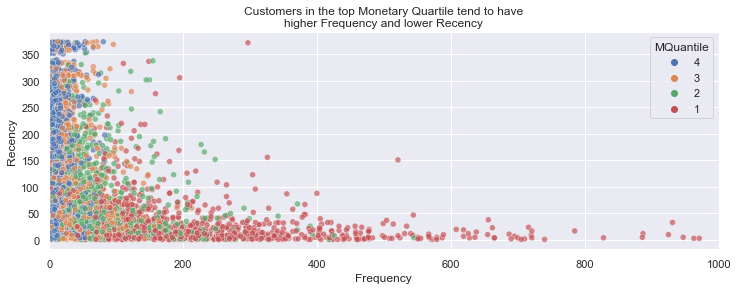

In [191]:
# Plot the 4 Monetary Quartiles for Frequency and Recency
ax = sns.scatterplot(x='Frequency', y='Recency', data=df_rfm, hue='MQuantile', alpha=2/3);
# Reduce the x axis limit to make visual interpretable
ax.set(xlim=(0,1000));
ax.set(title='Customers in the top Monetary Quartile tend to have\nhigher Frequency and lower Recency');

* We can also see that the higher the Customer spend, the greater the variability in the segment

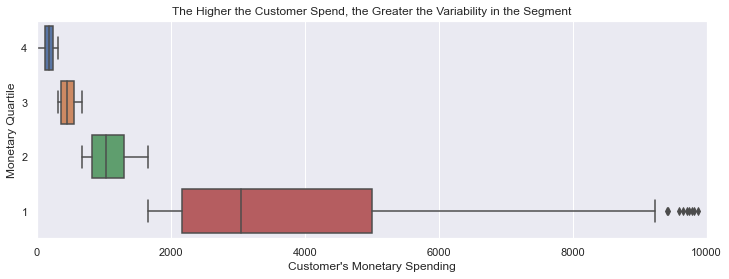

In [182]:
# Set plot figure size
sns.set(rc={'figure.figsize':(12,4)})
# Plot Box and Whisker fr each Monetary Quantile
ax = sns.boxplot(x=df_rfm['Monetary'],y=df_rfm['MQuantile']);
# Set Title
ax.set(title='The Higher the Customer Spend, the Greater the Variability in the Segment')
# Rename axis labels
ax.set(xlabel="Customer's Monetary Spending", ylabel='Monetary Quartile')
# Limit x axis so high spending customers don't distort the box-whisker plot
ax.set(xlim=(0, 10000));

# Save figure
plt.pyplot.savefig('../visuals/Monetary_Quartiles.png')

## Historically Big Spenders who have not Purchased Recently

* This will be customers who are in Monetary Quartile 1, and Frequency Quartile 4 (or 3 as well, depending on how many we wish to target)
* These are customers that brought in a lot of business previously, but have not made a purchase for a while.  
* They could be targetted with promotions enticing them to come back

In [214]:
df_rfm_m1r4 = df_rfm_m1[df_rfm_m1['RQuantile']==4].sort_values('Monetary', ascending=False)
df_rfm_m1r4.head(3)

,Recency,Frequency,Monetary,RQuantile,FQuantile,MQuantile,RFMScore
CustomerID,,,,,,,
15749.0,235,10,44534.30,4,4,1,441
15098.0,182,3,39916.50,4,4,1,441
12590.0,211,68,9864.26,4,2,1,421
